In [48]:
# Librerie
!pip install gplearn
!pip install pykan
!pip install -U "autora[theorist-bsr]" --pre


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import KAN
from gplearn.genetic import SymbolicRegressor
from autora.theorist.bsr import BSRRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Comparison of Symbolic Regression using Genetic Programming and Kolmogorov-Arnold Networks (KAN)

In this notebook, we will compare two **symbolic regression** techniques for learning this simple mathematical function:

$$
y = x^2 + x + 1
$$

1. **Genetic Programming**: We will use the **gplearn** library, which implements genetic programming, to find a symbolic representation of the function \( y = x^2 + x + 1 \) using evolutionary techniques.
   
2. **Kolmogorov-Arnold-Networks (KAN)**: We will train a KAN using the official **PyKAN** library, to perform symbolic regression.


# Dataset definition and plotting

In [57]:
# Function to create dataset
def create_dataset(function, n_var, ranges, train_num=5000, test_num=1000, noise_level=5, normalize_label=True, normalize_input=True):
    # Training data
    X_train = torch.linspace(ranges[0], ranges[1], train_num).view(-1, 1)
    y_train = function(X_train)

    # Adding Gaussian noise to training data
    noise_train = torch.tensor(np.random.normal(0, noise_level, X_train.shape), dtype=torch.float32)
    y_train += noise_train

    # Test data
    X_test = torch.linspace(ranges[0], ranges[1], test_num).view(-1, 1)
    y_test = function(X_test)

    # Adding Gaussian noise to test data
    noise_test = torch.tensor(np.random.normal(0, noise_level, X_test.shape), dtype=torch.float32)
    y_test += noise_test

    # Normalization
    if normalize_input:
        X_train = (X_train - X_train.mean()) / X_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()
    if normalize_label:
        y_train = (y_train - y_train.mean()) / y_train.std()
        y_test = (y_test - y_test.mean()) / y_test.std()

    dataset = {
        "train_input": X_train, "train_label": y_train,
        "test_input": X_test, "test_label": y_test
    }
    return dataset


quadratic_function = lambda x: x**2 + x + 1
dataset = create_dataset(quadratic_function, n_var=1, ranges=[-10, 10], train_num=5000, test_num=1000, noise_level=5, normalize_label=True, normalize_input=True)

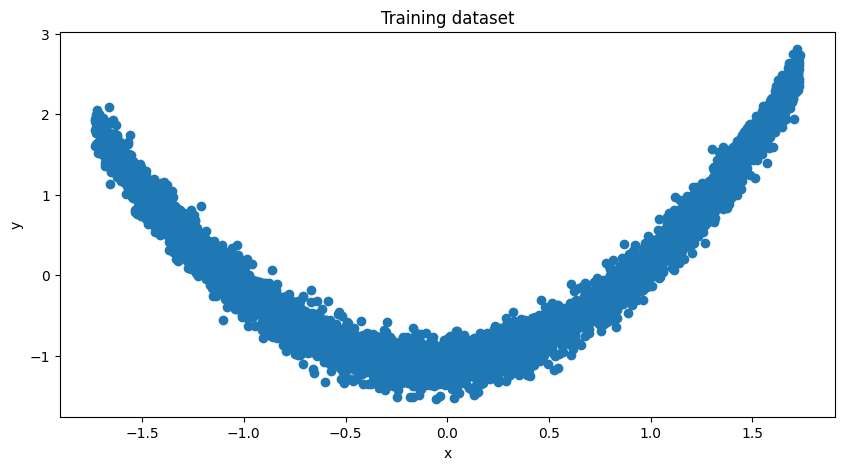

In [11]:
fig, ax = plt.subplots()
ax.scatter(dataset["train_input"].cpu(), dataset["train_label"].cpu())
fig.set_size_inches(10, 5)
plt.title('Training dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Training with KAN

In [12]:
model = KAN(width=[1, 1], grid=40, k=3, seed=0)
model.fit(dataset, opt="LBFGS", steps=300, lamb=0.001, lamb_entropy=4)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 1.57e-01 | reg: 4.98e+00 | : 100%|█| 300/300 [00:20<00:00, 14.50


saving model version 0.1


{'train_loss': [array(0.1614451, dtype=float32),
  array(0.16086783, dtype=float32),
  array(0.16086732, dtype=float32),
  array(0.16086732, dtype=float32),
  array(0.16086732, dtype=float32),
  array(0.16086729, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086687, dtype=float32),
  array(0.16086

In [13]:
symbolic_suggestion = model.suggest_symbolic(0, 0, 0)
print(symbolic_suggestion)

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       x^2    0.999688 -11.601852           2                2   -0.720370
1       cos    0.999530 -11.024730           2                2   -0.604946
2       sin    0.999513 -10.975246           2                2   -0.595049
3         0    0.000000   0.000014           0                0    0.000003
4  gaussian    0.999667 -11.508454           3                3    0.098309
('x^2', (<function <lambda> at 0x7f66ad8db520>, <function <lambda> at 0x7f66ad8db5b0>, 2, <function <lambda> at 0x7f66ad8db640>), 0.9996882677078247, 2)


In [14]:
model.fix_symbolic(0, 0, 0, 'x^2')

r2 is 0.9996882677078247
saving model version 0.2


tensor(0.9997)

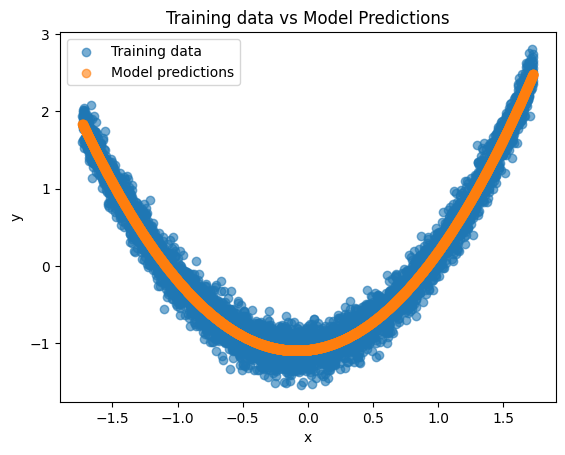

In [17]:
# Get the model predictions on the training input
with torch.no_grad():
    predictions = model(dataset['train_input'])

# Plot
fig, ax = plt.subplots()
ax.scatter(dataset['train_input'].cpu(), dataset['train_label'].cpu(), label='Training data', alpha=0.6)
ax.scatter(dataset['train_input'].cpu(), predictions.cpu(), label='Model predictions', alpha=0.6)


plt.title('Training data vs Model Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


1.08332861480151*(-x - 0.0861308120637573)**2 - 1.09117484092712

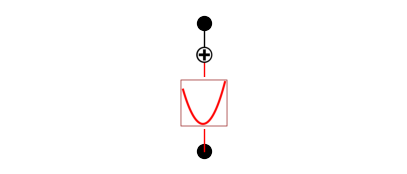

In [25]:
model.plot()

formula, variables = model.symbolic_formula(var=['x'])
formula[0]

# Train with Genetic Programming

In [40]:
X_train = dataset['train_input'].numpy()
y_train = dataset['train_label'].numpy()

In [41]:
# Configuration of the symbolic regressor
est = SymbolicRegressor(
    population_size=2000,
    generations=50,
    tournament_size=30,
    stopping_criteria=0.01,
    const_range=(-1.0, 1.0),
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.01,
    random_state=0
)

In [42]:
# Training
est.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41          22508.9        7         0.280989         0.282223      2.95m
   1     9.70          1.75849        5         0.222687         0.225831      2.52m
   2     7.70          5.59179       31         0.184809         0.188837      1.56m
   3     7.77          1.78781        9          0.14762          0.15177      1.39m
   4     5.69          1.07669        9         0.147922         0.149051      1.52m
   5     5.43         0.952241        9          0.14729         0.154741      1.27m
   6     6.58          1.21271        9         0.146225         0.164328      1.28m
   7     7.10         0.955681        9         0.146933         0.157952      1.64m
   8     7.21          1.86656        7         0.154474          0.17085  

SymbolicRegressor(generations=50, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=2000, random_state=0, stopping_criteria=0.01,
                  tournament_size=30, verbose=1)

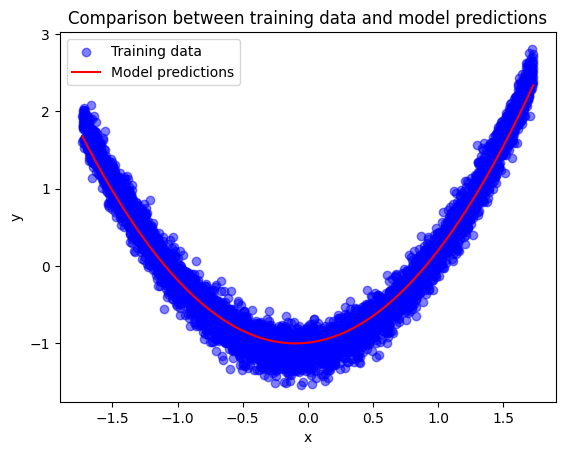

In [43]:
# Model predictions on the training data
y_pred = est.predict(X_train)

# Plot
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, color='blue', label='Training data', alpha=0.5)
sorted_idx = np.argsort(X_train[:, 0])
ax.plot(X_train[sorted_idx], y_pred[sorted_idx], color='red', label='Model predictions')


plt.title('Comparison between training data and model predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [46]:
print('Formula:', est._program)

Formula: add(mul(add(0.191, X0), X0), -0.991)


In [45]:
# Mean Squared Error
mse = mean_squared_error(y_train, y_pred)

# R^2 coefficient of determination
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2): {r2}")

Errore Quadratico Medio (MSE): 0.03185133195076117
Coefficiente di Determinazione (R^2): 0.9681422957917769


# Train with BSR Regressor

In [58]:
X_train = dataset['train_input'].numpy()
y_train = dataset['train_label'].numpy()
X_test = dataset['test_input'].numpy()
y_test = dataset['test_label'].numpy()